In [1]:
import os
from convokit import download, Corpus
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [14]:
def extract_dynamic_samples(all_predictions, corpus, corpus_name):
    label_metadata = "conversation_has_personal_attack" if corpus_name == "wikiconv" else "has_removed_comment"
    num_convo = 0
    hard_pos, hard_neg = 0, 0
    all_pos, all_neg = 0, 0
    dynamic_samples = []
    test_samples = []
    for convo in corpus.iter_conversations():
        if convo.meta['split'] == 'test':
            test_samples.append(convo.id)
            max_agreement = 0
            for utterance in convo.iter_utterances():
                id = utterance.id
                if id in all_predictions:
                    if all_predictions[id] > max_agreement:
                        max_agreement = all_predictions[id]
            if convo.meta[label_metadata] == False:
                all_neg += 1
                if max_agreement >= 3:
                    hard_neg += 1
                    dynamic_samples.append(convo.id)
            else:
                all_pos += 1
                if max_agreement <= 8:
                    hard_pos += 1
                    dynamic_samples.append(convo.id)
    print("We have {} positive samples and {} negative samples in the test set".format(all_pos, all_neg))
    # print("We have {} positive samples and {} negative dynamic samples".format(hard_pos, hard_neg))

    single_samples = [id for id in test_samples if id not in dynamic_samples]
    print(len(dynamic_samples))
    print(len(single_samples))
    return test_samples, dynamic_samples, single_samples
def test(test_samples, pred_path, corpus, corpus_name):
    print(pred_path)
    label_metadata = "conversation_has_personal_attack" if corpus_name == "wikiconv" else "has_removed_comment"
    pred_file = open(pred_path, 'r')
    pred_lines = pred_file.readlines()[1:]
    pred_dict = {}
    for line in pred_lines:
        id2pred = line.split(",")
        
        assert len(id2pred) == 3
        utt_id = id2pred[0]
        utt_pred = id2pred[1]
        pred_dict[utt_id] = int(utt_pred)
        
    for convo in corpus.iter_conversations():
        # only consider test set conversations (we did not make predictions for the other ones)
        if convo.id in test_samples:
            for utt in convo.iter_utterances():
                if utt.id in pred_dict:
                    utt.meta['forecast_score'] = pred_dict[utt.id]
    
    conversational_forecasts_df = {
            "convo_id": [],
            "label": [],
            "prediction": []
        }
    for convo in corpus.iter_conversations():
        if convo.id in test_samples:
            conversational_forecasts_df['convo_id'].append(convo.id)
            conversational_forecasts_df['label'].append(int(convo.meta[label_metadata]))
            forecast_scores = [utt.meta['forecast_score'] for utt in convo.iter_utterances() if 'forecast_score' in utt.meta]
            conversational_forecasts_df['prediction'].append(max(forecast_scores))
    conversational_forecasts_df = pd.DataFrame(conversational_forecasts_df).set_index("convo_id")
    test_labels = conversational_forecasts_df.label
    test_preds = conversational_forecasts_df.prediction
    test_acc = (test_labels == test_preds).mean()
    
    tp = ((test_labels==1)&(test_preds==1)).sum()
    fp = ((test_labels==0)&(test_preds==1)).sum()
    tn = ((test_labels==0)&(test_preds==0)).sum()
    fn = ((test_labels==1)&(test_preds==0)).sum()

    test_precision = tp / (tp + fp)
    test_recall = tp / (tp + fn)
    test_fpr = fp / (fp + tn)
    test_f1 = 2 / (((tp + fp) / tp) + ((tp + fn) / tp))
    return {"accuracy":test_acc, "precision":test_precision, "recall":test_recall, "f1":test_f1}
    

In [15]:
def get_single_utt_preds(saved_path):
    single_utt_predictions = {}
    all_seeds = os.listdir(saved_path)
    for seed in all_seeds:
        pred_path = os.path.join(saved_path, seed, "predictions.csv")
        pred_file = open(pred_path, 'r')
        pred_lines = pred_file.readlines()[1:]
        for line in pred_lines:
            id2pred = line.split(",")
            
            assert len(id2pred) == 3
            utt_id = id2pred[0]
            utt_pred = id2pred[1]
            if utt_id not in single_utt_predictions:
                single_utt_predictions[utt_id] = int(utt_pred)
            else:
                single_utt_predictions[utt_id] += int(utt_pred)
    return single_utt_predictions
    
def full_evaluate(full_model_name, full_model_path, single_model_name, single_model_path, corpus, corpus_name):
    single_model_path = os.path.join(single_model_path, corpus_name, single_model_name)
    full_model_path = os.path.join(full_model_path, corpus_name, full_model_name)
    
    single_utt_predictions = get_single_utt_preds(single_model_path)
    test_samples, dynamic_samples, single_samples = extract_dynamic_samples(single_utt_predictions, corpus, corpus_name)

    with open('{}.txt'.format(corpus_name), 'w') as f:
        for id in dynamic_samples:
            f.write("%s\n" % id)

    result_dict = {"full_test": {"accuracy":[], "precision":[], "recall":[], "f1":[]},
                  "dynamic_only": {"accuracy":[], "precision":[], "recall":[], "f1":[]},
                  "single_enough": {"accuracy":[], "precision":[], "recall":[], "f1":[]}}

    for seed in range(1,5):        
        try:
            pred_path = os.path.join(full_model_path, "seed-{}".format(seed), "predictions.csv")
            full_test = test(test_samples, pred_path, corpus, corpus_name)
            for metric in full_test:
                result_dict['full_test'][metric].append(full_test[metric])
            dynamic_only = test(dynamic_samples, pred_path, corpus, corpus_name)
            for metric in dynamic_only:
                result_dict['dynamic_only'][metric].append(dynamic_only[metric])
            single_enough = test(single_samples, pred_path, corpus, corpus_name)
            for metric in single_enough:
                result_dict['single_enough'][metric].append(single_enough[metric])
        except:
            continue
    for metric in result_dict['full_test']:
        result_dict['full_test'][metric] = np.mean(result_dict['full_test'][metric])
        result_dict['dynamic_only'][metric] = np.mean(result_dict['dynamic_only'][metric])
        result_dict['single_enough'][metric] = np.mean(result_dict['single_enough'][metric])
    return result_dict

In [4]:
wikicorpus = Corpus(filename=download("conversations-gone-awry-corpus"))
cmvcorpus = Corpus(filename=download("conversations-gone-awry-cmv-corpus"))

Dataset already exists at /home/sqt2/.convokit/downloads/conversations-gone-awry-corpus
Dataset already exists at /home/sqt2/.convokit/downloads/conversations-gone-awry-cmv-corpus


In [16]:
full_model_path = "/reef/sqt2/BERTCRAFT_adversarial"
single_model_path = "/reef/sqt2/SINGLE_UTT"

In [17]:
print(full_evaluate("unitary/unbiased-toxic-roberta", full_model_path, "roberta-base", single_model_path, wikicorpus, 'wikiconv'))

We have 420 positive samples and 420 negative samples in the test set
420
420
/reef/sqt2/BERTCRAFT_adversarial/wikiconv/unitary/unbiased-toxic-roberta/seed-1/predictions.csv
/reef/sqt2/BERTCRAFT_adversarial/wikiconv/unitary/unbiased-toxic-roberta/seed-1/predictions.csv
/reef/sqt2/BERTCRAFT_adversarial/wikiconv/unitary/unbiased-toxic-roberta/seed-1/predictions.csv
/reef/sqt2/BERTCRAFT_adversarial/wikiconv/unitary/unbiased-toxic-roberta/seed-2/predictions.csv
/reef/sqt2/BERTCRAFT_adversarial/wikiconv/unitary/unbiased-toxic-roberta/seed-2/predictions.csv
/reef/sqt2/BERTCRAFT_adversarial/wikiconv/unitary/unbiased-toxic-roberta/seed-2/predictions.csv
/reef/sqt2/BERTCRAFT_adversarial/wikiconv/unitary/unbiased-toxic-roberta/seed-3/predictions.csv
/reef/sqt2/BERTCRAFT_adversarial/wikiconv/unitary/unbiased-toxic-roberta/seed-3/predictions.csv
/reef/sqt2/BERTCRAFT_adversarial/wikiconv/unitary/unbiased-toxic-roberta/seed-3/predictions.csv
/reef/sqt2/BERTCRAFT_adversarial/wikiconv/unitary/unbiased

In [20]:
# Performance of single_utterance models
print(full_evaluate("roberta-base", single_model_path, "roberta-base", single_model_path, wikicorpus, 'wikiconv'))

We have 420 positive samples and 420 negative samples in the test set
420
420
{'full_test': {'accuracy': nan, 'precision': nan, 'recall': nan, 'f1': nan}, 'dynamic_only': {'accuracy': nan, 'precision': nan, 'recall': nan, 'f1': nan}, 'single_enough': {'accuracy': nan, 'precision': nan, 'recall': nan, 'f1': nan}}


In [21]:
print(full_evaluate("roberta-base", full_model_path, "roberta-base", single_model_path, cmvcorpus, 'cmv'))

We have 684 positive samples and 684 negative samples in the test set
643
725
{'full_test': {'accuracy': 0.6663011695906432, 'precision': 0.64520218216768, 'recall': 0.7437865497076024, 'f1': 0.689526319826724}, 'dynamic_only': {'accuracy': 0.4105754276827372, 'precision': 0.48311612143201516, 'recall': 0.547683923705722, 'f1': 0.5119095749952028}, 'single_enough': {'accuracy': 0.8931034482758621, 'precision': 0.8216889897322677, 'recall': 0.970820189274448, 'f1': 0.8888516134821489}}


In [16]:
# Performance of single_utterance models
print(full_evaluate("roberta-base", single_model_path, "roberta-base", single_model_path, cmvcorpus, 'cmv'))

We have 684 positive samples and 684 negative samples in the test set
643
725
{'full_test': {'accuracy': nan, 'precision': nan, 'recall': nan, 'f1': nan}, 'dynamic_only': {'accuracy': nan, 'precision': nan, 'recall': nan, 'f1': nan}, 'single_enough': {'accuracy': nan, 'precision': nan, 'recall': nan, 'f1': nan}}


# Test BERT

In [19]:
print(full_evaluate("bert-base-cased", full_model_path, "roberta-base", single_model_path, wikicorpus, 'wikiconv'))

We have 420 positive samples and 420 negative samples in the test set
420
420
{'full_test': {'accuracy': 0.6498809523809526, 'precision': 0.6481755354732142, 'recall': 0.6571428571428571, 'f1': 0.6514259362456893}, 'dynamic_only': {'accuracy': 0.4333333333333333, 'precision': 0.4458313926721707, 'recall': 0.4700934579439252, 'f1': 0.45652203723023616}, 'single_enough': {'accuracy': 0.8664285714285714, 'precision': 0.8743310779059899, 'recall': 0.8514563106796116, 'f1': 0.8615805508801134}}


In [20]:
print(full_evaluate("bert-base-cased", full_model_path, "roberta-base", single_model_path, cmvcorpus, 'cmv'))

We have 684 positive samples and 684 negative samples in the test set
643
725
{'full_test': {'accuracy': 0.6244152046783626, 'precision': 0.6224945546759315, 'recall': 0.6369883040935672, 'f1': 0.6275914708902823}, 'dynamic_only': {'accuracy': 0.3954898911353032, 'precision': 0.46484683255368076, 'recall': 0.44114441416893735, 'f1': 0.45079635565041143}, 'single_enough': {'accuracy': 0.8274482758620689, 'precision': 0.7741078898511187, 'recall': 0.8637223974763406, 'f1': 0.8143807917502528}}


In [21]:
print(full_evaluate("bert-base-cased", single_model_path, "roberta-base", single_model_path, wikicorpus, 'wikiconv'))

We have 420 positive samples and 420 negative samples in the test set
420
420
{'full_test': {'accuracy': 0.6370238095238095, 'precision': 0.6254843785058992, 'recall': 0.6907142857142857, 'f1': 0.6542726112219576}, 'dynamic_only': {'accuracy': 0.38761904761904764, 'precision': 0.4086602064800749, 'recall': 0.46775700934579445, 'f1': 0.4336618353471935}, 'single_enough': {'accuracy': 0.8864285714285713, 'precision': 0.8595774284360708, 'recall': 0.9223300970873787, 'f1': 0.8885230734952267}}


In [22]:
print(full_evaluate("bert-base-cased", single_model_path, "roberta-base", single_model_path, cmvcorpus, 'cmv'))

We have 684 positive samples and 684 negative samples in the test set
643
725
{'full_test': {'accuracy': 0.6410087719298245, 'precision': 0.6295941085158379, 'recall': 0.6896198830409357, 'f1': 0.656542552593613}, 'dynamic_only': {'accuracy': 0.38522550544323486, 'precision': 0.46031288275988835, 'recall': 0.4852861035422344, 'f1': 0.4704443204045079}, 'single_enough': {'accuracy': 0.8678620689655172, 'precision': 0.805002889737592, 'recall': 0.9261829652996845, 'f1': 0.8601942456653507}}


# Survey length two sets

In [13]:
# def simple_survey_convo(convo_ids, corpus, set_name):
#     num_utterances = []
#     len_utterance = []
#     len_convo = []
#     for convo in corpus.iter_conversations():
#         if convo.id in convo_ids:
#             num_utterances.append(len(convo.get_chronological_utterance_list()))
#             current_l_utt = [len(u.text.split(" ")) for u in convo.iter_utterances()]
#             len_utterance.extend(current_l_utt)
#             len_convo.append(sum(current_l_utt))
#     print(np.mean(num_utterances))
#     print(np.mean(len_utterance))
#     print(np.mean(len_convo))
#     plt.hist(num_utterances, color ='blue')
#     plt.xlabel('Number of Utterances each conversation.')
#     plt.ylabel('Number of Conversations')
     
#     plt.title('{} : Num Utterances\n\n'.format(set_name),
#               fontweight = "bold")
#     plt.show()
#     plt.hist(len_utterance, color ='red')
#     plt.xlabel('Number of Words each Utterances.')
#     plt.ylabel('Number of Utterances')
#     plt.show()
#     # plt.hist(len_convo)
#     # plt.show()

We have 0 positive samples and 840 negative samples in the test set
201
639
7.437810945273632
65.76387959866221
489.1393034825871


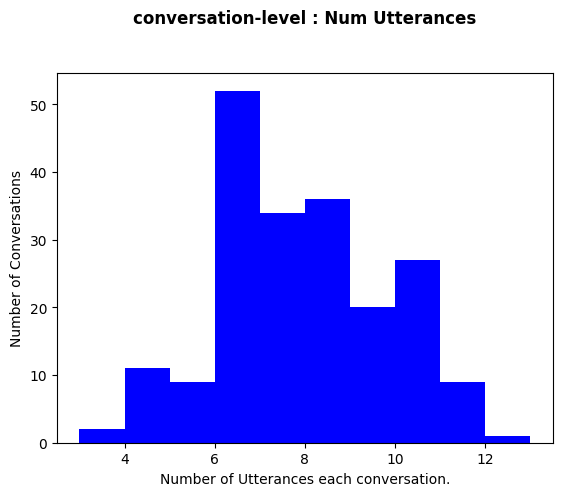

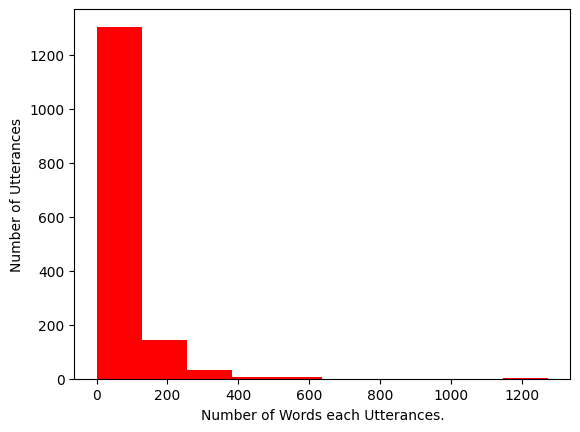

7.004694835680751
69.69593386952636
488.19874804381845


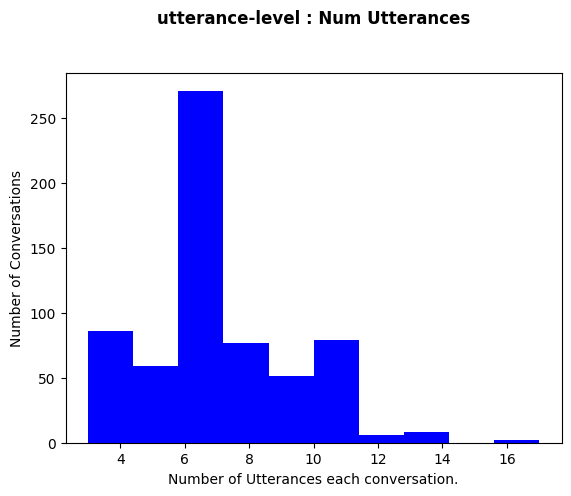

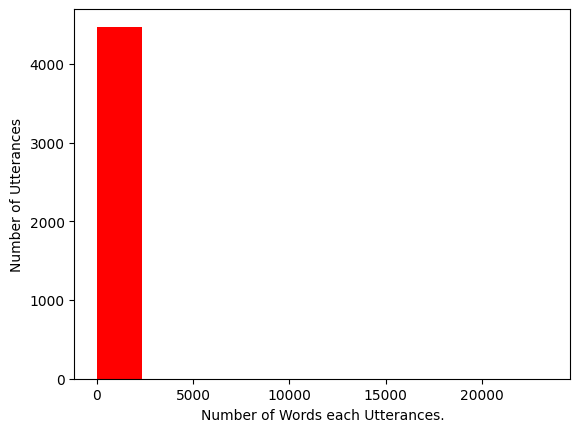

In [14]:
# single_model_path = "/reef/sqt2/SINGLE_UTT"

# single_model_path = os.path.join(single_model_path, 'wikiconv', 'roberta-base')

# single_utt_predictions = get_single_utt_preds(single_model_path)
# test_samples, dynamic_samples, single_samples = extract_dynamic_samples(single_utt_predictions, wikicorpus, 'wikiconv')
# simple_survey_convo(dynamic_samples, wikicorpus, 'conversation-level')
# simple_survey_convo(single_samples, wikicorpus, 'utterance-level')


In [15]:
# for convo in wikicorpus.iter_conversations():
#     for utt in convo.iter_utterances():
#         print(utt.text)
#         break
#     break

== [WIKI_LINK: WP:COMMONNAME] ==



# Do they fix a derailing conversation?

In [29]:
# single_model_path = "/reef/sqt2/SINGLE_UTT/wikiconv/roberta-base"
# all_predictions = get_single_utt_preds(single_model_path)
# for derail_id in all_predictions:
#     if all_predictions[derail_id] == 10:
#         print_next = False
#         for convo in wikicorpus.iter_conversations():
#             if convo.meta['split'] == 'test':
#                 # if convo.meta['has_removed_comment'] == False:
#                 if convo.meta['conversation_has_personal_attack'] == False:
#                     for utterance in convo.iter_utterances():
#                         if print_next:
#                             print("\t\t\tReply:", utterance.text)
#                             print("\n\n\n\n\n\n")
#                             print_next = False
#                         id = utterance.id
#                         if id == derail_id:
#                             print("\tTrigger:", utterance.text)
#                             print_next = True

	Trigger: All you guys chasing each other around in an edit war, sometimes just to piss on the other guy, creating puppets, endless reverts, pointless name-calling...etc. Stop! Go somewhere else. Go to a Taiwan\China discussion forum on the internet or take it outside. I don't want to see it here anymore. Wikipedia does not have a Wiki-kids encyclopedia yet, so until then, don't contribute. You guys chase each other all over wikipedia looking for a fight and then get all primed for conflict, so when a guy like me comes along to add quality information from quality sources, I have to put up with a bunch of impulsive, angry, POV people, who, because of conflict with someone I don't even know, or care to know, can't/won't cooperate. I am really beginning to think you all enjoy the fighting and perpetuate it. Would someone please take the high road? This page has the potential to be a really great, really useful, really informative page...but that is not going to happen if you keep fightin

In [28]:
# single_model_path = "/reef/sqt2/SINGLE_UTT/cmv/roberta-base"
# all_predictions = get_single_utt_preds(single_model_path)
# for derail_id in all_predictions:
#     if all_predictions[derail_id] == 10:
#         print_next = False
#         for convo in cmvcorpus.iter_conversations():
#             if convo.meta['split'] == 'test':
#                 if convo.meta['has_removed_comment'] == False:
#                 # if convo.meta['conversation_has_personal_attack'] == False:
#                     for utterance in convo.iter_utterances():
#                         if print_next:
#                             print("\t\t\tReply:", utterance.text)
#                             print("\n\n\n\n\n\n")
#                             print_next = False
#                         id = utterance.id
#                         if id == derail_id:
#                             print("\tTrigger:", utterance.text)
#                             print_next = True

	Trigger: Having a penis is a *little* different than being ugly or handicapped. Your analogies are irrelevant and invalid.
			Reply: &gt; Consent was gained by deceit, not allowing the victim the ability to engage their full faculties in the decision to have sex

And lying about the items I mentioned above can rightfully be considered deceit. If someone says "I'll never have sex with a Jewish person because I hate Jews", is it not fraud/deceit to lie to that person if I'm of Jewish heritage? I know they would never have sex with me if I were being honest, so I lie.

It might not be the same magnitude of lying about gender, but it is still lying in order to get sex. What threshold is passed that makes lying about gender "rape by fraud" but lying about other things not?







	Trigger: A conspiracy requires two or more people orchestrating a plot. With one person, it is no longer a conspiracy. Are you going to refute my points or just go off on tangents?
			Reply: Your conspiracy would

# Transfer Learning Quick Survey

In [5]:
full_model_path = "/reef/sqt2/BERTCRAFT_adversarial"

In [8]:
print(full_evaluate("roberta-base", full_model_path, "roberta-base", single_model_path, wikicorpus, 'wikiconv'))

We have 420 positive samples and 420 negative samples in the test set
420
420
{'full_test': {'accuracy': 0.6750000000000002, 'precision': 0.6682313930525661, 'recall': 0.6968253968253967, 'f1': 0.6816545122658741}, 'dynamic_only': {'accuracy': 0.44920634920634916, 'precision': 0.46141772941304365, 'recall': 0.4906542056074767, 'f1': 0.4749413445223372}, 'single_enough': {'accuracy': 0.9007936507936508, 'precision': 0.8901902444577251, 'recall': 0.9110032362459547, 'f1': 0.9000989291667937}}


In [7]:
print(full_evaluate("bert-base-cased", full_model_path, "roberta-base", single_model_path, wikicorpus, 'wikiconv'))

We have 420 positive samples and 420 negative samples in the test set
420
420
{'full_test': {'accuracy': nan, 'precision': nan, 'recall': nan, 'f1': nan}, 'dynamic_only': {'accuracy': nan, 'precision': nan, 'recall': nan, 'f1': nan}, 'single_enough': {'accuracy': nan, 'precision': nan, 'recall': nan, 'f1': nan}}


/reef/conda-envs/jacq-zissou-env-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/reef/conda-envs/jacq-zissou-env-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
print(full_evaluate("roberta-base", single_model_path, "roberta-base", single_model_path, cmvcorpus, 'cmv'))

We have 684 positive samples and 684 negative samples in the test set
643
725
{'full_test': {'accuracy': 0.6599415204678363, 'precision': 0.6612345664184509, 'recall': 0.6574561403508772, 'f1': 0.6585149467686928}, 'dynamic_only': {'accuracy': 0.30186625194401245, 'precision': 0.38138703212035224, 'recall': 0.3705722070844687, 'f1': 0.3746641148826718}, 'single_enough': {'accuracy': 0.9775172413793103, 'precision': 0.9608978253124519, 'recall': 0.989589905362776, 'f1': 0.974818811248263}}


In [15]:
print(full_evaluate("bert-base-cased", single_model_path, "roberta-base", single_model_path, cmvcorpus, 'cmv'))

We have 684 positive samples and 684 negative samples in the test set
643
725
{'full_test': {'accuracy': 0.6410087719298245, 'precision': 0.6295941085158379, 'recall': 0.6896198830409357, 'f1': 0.656542552593613}, 'dynamic_only': {'accuracy': 0.38522550544323486, 'precision': 0.46031288275988835, 'recall': 0.4852861035422344, 'f1': 0.4704443204045079}, 'single_enough': {'accuracy': 0.8678620689655172, 'precision': 0.805002889737592, 'recall': 0.9261829652996845, 'f1': 0.8601942456653507}}


In [16]:
for i in range(4):
    print(i)

0
1
2
3
